In [1]:
# Introduction: This code comes from my final project in "Marketing Analytics" course in my undergrad. 
## In this project, we obtain a dataset from open-source database of Instacart. The dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. 
## Based on a Gradient Boosting Decision Tree model, this analysis would predict whether users will make repurchase decisions with their latest order in the test data. The GBDT is a kind of machine learning based on the decision tree model. We use the lightGBM framework to perform the GBDT model in this analysis since lightGBM has a faster training speed, better accuracy, and low occupation of computer storage space than XGBoosts. 
## Since the last order of users is separated into the training and test datasets, we built the prediction model based on the training datasets for more accuracy. To get the reordering record of each order in the training datasets, we first merge the dataset of "orders.csv" and "order_product_train.csv", according to user id and product id, and then use the "test_train_splict" function and a fraction of 0.9 to separate the training and validate datasets. 
## Then, based on the classification variables of "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order", the lightGBM model would be used to perform the prediction. We chose the "order_number" variable since a larger number of orders could mean a higher loyalty level, which would positively correlate with repurchase behavior. Moreover, longer days since the prior order could also yield repurchase behavior.  
## We classified probability > 0.5 as "reorder = 1", and "reorder" is a binary variable used for prediction. After adjusting the number of leaves (96) and maximum depth (10), and begging frequency of 5 to reduce the overfitting problem, we applied the model to the "validate" datasets and compared it with the actual reorder result. A relatively high f-score of 72.6% is detected. The result indicates that the model could have good predictive correctness. 
## Eventually, the model is applied to the test datasets, and it shows that 52,713 users, among 75,000 in total, would have repurchase behavior in the latest order, as shown in Figure 24. This analysis would help Instacart better target and retain loyal consumers with repurchase behavior.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path= "D:\港中深\Courses\MKT3310\Final Project\instacart-market-basket-analysis/"
orders = pd.read_csv(path + 'orders.csv')
order_products__train = pd.read_csv(path + 'order_products__train.csv')
order_products__prior = pd.read_csv(path + 'order_products__prior.csv')

# Split the orders dataset into historical dataset, training set, and testing set based on the eval_set category
orders_prior_data=orders.loc[orders.eval_set=='prior']
orders_train_data=orders.loc[orders.eval_set=='train']
orders_test_data=orders.loc[orders.eval_set=='test']

priors=order_products__prior.merge(orders_prior_data,on=['order_id'],how='left')
trains = order_products__train.merge(orders_train_data, on =['order_id'], how='left')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [62]:
import os
import datetime
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
trains.drop(['eval_set', 'user_id', 'product_id', 'order_id', 'add_to_cart_order'], axis=1, inplace=True)
trains.head()

,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,4,4,10,9.0
1,1,4,4,10,9.0
2,0,4,4,10,9.0
3,0,4,4,10,9.0
4,1,4,4,10,9.0


In [63]:
X_train, X_val, y_train, y_val = train_test_split(trains.drop('reordered', axis=1), trains.reordered, test_size=0.9, random_state=42)

In [64]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')   
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [162]:
# trian
import numpy as np
import lightgbm as lgb
labels = np.array(y_train, dtype=np.int8)
d_train = lgb.Dataset(X_train,
                      label=labels)   
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100
watchlist=[d_train]

lgb_start=datetime.now()
bst = lgb.train(params=params, train_set=d_train, num_boost_round=ROUNDS,valid_sets=watchlist,verbose_eval=10)
lgb_end=datetime.now()
print ('spendt time :'+str((lgb_end-lgb_start).seconds)+'(s)')

C:\python\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 82878, number of negative: 55583
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 138461, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598566 -> initscore=0.399492
[LightGBM] [Info] Start training from score 0.399492
[10]	training's binary_logloss: 0.635139
[20]	training's binary_logloss: 0.627788
[30]	training's binary_logloss: 0.624872
[40]	training's binary_logloss: 0.622691
[50]	training's binary_logloss: 0.620752
[60]	training's binary_logloss: 0.619061
[70]	training's binary_logloss: 0.617357
[80]	training's binary_logloss: 0.615676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [66]:
# apply the trained model into validation dataset
predict=bst.predict(X_val) 

X_val['reorder']=y_val
X_val['pre']=predict

print ("test score is :")
precision=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['pre']>0.5]))   # predict score>0.5 and lables=1 nums divied predict score>0.5 nums
recall=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['reorder']==1]))     # predict score>0.5 and lables=1 nums divied lables=1
f1_score=2*(precision*recall)/(precision+recall)
print ('F1 score is :'+str(f1_score))

test score is :
F1 score is :0.725649620098628


In [89]:
trains.groupby('reordered').count()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
reordered,,,,
0,555793,555793,555793,555793
1,828824,828824,828824,828824


In [131]:
#predict test集数据
test=orders.loc[orders.eval_set=='test']
test["reorder"] = ""
test.head()

C:\Users\陈睿\AppData\Local\Temp/ipykernel_19432/2862818607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["reorder"] = ""


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder
38,2774568,3,test,13,5,15,11.0,
44,329954,4,test,6,3,12,30.0,
53,1528013,6,test,4,3,16,22.0,
96,1376945,11,test,8,6,11,8.0,
102,1356845,12,test,6,1,20,30.0,


In [132]:
x_test, y_test = (test.drop(['eval_set', 'user_id', 'order_id','reorder'], axis=1), test.reorder)

In [134]:
#Model prediction in the test dataset
predict=bst.predict(x_test) 

x_test['reorder']=y_test
x_test['pre']=predict

In [135]:
pre = x_test['pre']
pre.head()

38     0.648228
44     0.415173
53     0.476560
96     0.538556
102    0.390439
Name: pre, dtype: float64

In [136]:
x_test['reorder'].head()

38     
44     
53     
96     
102    
Name: reorder, dtype: object

In [137]:
x_test.loc[(x_test.pre >= 0.5) ,'reorder'] = '1'
x_test.loc[(x_test.pre < 0.5) ,'reorder'] = '0'

In [138]:
result = pd.concat([test, x_test], axis=1)
result

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder,pre
38,2774568,3,test,13,5,15,11.0,,13,5,15,11.0,1,0.648228
44,329954,4,test,6,3,12,30.0,,6,3,12,30.0,0,0.415173
53,1528013,6,test,4,3,16,22.0,,4,3,16,22.0,0,0.476560
96,1376945,11,test,8,6,11,8.0,,8,6,11,8.0,1,0.538556
102,1356845,12,test,6,1,20,30.0,,6,1,20,30.0,0,0.390439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0,,23,2,17,6.0,1,0.741289
3420929,350108,206204,test,5,4,14,14.0,,5,4,14,14.0,0,0.497647
3421001,1043943,206206,test,68,0,20,0.0,,68,0,20,0.0,1,0.719126
3421018,2821651,206207,test,17,2,13,14.0,,17,2,13,14.0,1,0.686079


In [114]:
result.reorder.describe()

,reorder,reorder
count,75000,75000
unique,1,2
top,,1
freq,75000,52713


In [139]:
result.to_csv('prediction.csv',index = None)

In [144]:
result1 = pd.read_csv('prediction.csv')
result1

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder,pre
0,2774568,3,13,5,15,11,1,0.648228
1,329954,4,6,3,12,30,0,0.415173
2,1528013,6,4,3,16,22,0,0.476560
3,1376945,11,8,6,11,8,1,0.538556
4,1356845,12,6,1,20,30,0,0.390439
...,...,...,...,...,...,...,...,...
74995,2728930,206202,23,2,17,6,1,0.741289
74996,350108,206204,5,4,14,14,0,0.497647
74997,1043943,206206,68,0,20,0,1,0.719126
74998,2821651,206207,17,2,13,14,1,0.686079


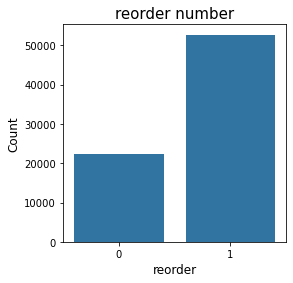

In [151]:
import seaborn as sns
color = sns.color_palette()

plt.figure(figsize=(4, 4))
sns.countplot(x="reorder", data=result1, color=color[0])
plt.ylabel("Count", fontsize=12)
plt.xlabel("reorder", fontsize=12)
plt.title("reorder number", fontsize=15)
plt.show()

In [160]:
reorder_user = result1.loc[result1['reorder'] ==1]

In [161]:
reorder_user

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder,pre
0,2774568,3,13,5,15,11,1,0.648228
3,1376945,11,8,6,11,8,1,0.538556
5,2161313,15,23,1,9,7,1,0.806046
6,1416320,16,7,0,13,7,1,0.575348
7,1735923,19,10,6,17,8,1,0.579744
...,...,...,...,...,...,...,...,...
74994,309211,206201,33,0,12,11,1,0.773845
74995,2728930,206202,23,2,17,6,1,0.741289
74997,1043943,206206,68,0,20,0,1,0.719126
74998,2821651,206207,17,2,13,14,1,0.686079
